In [ ]:
!echo '{"username":"pyingqi18","key":"7e39c02c8c6d02a515ff76af4b648c2a"}' > kaggle.json
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download mehradaria/covid19-lung-ct-scans
#!unzip covid19-lung-ct-scans.zip
!kaggle datasets download -d azaemon/preprocessed-ct-scans-for-covid19
!unzip preprocessed-ct-scans-for-covid19.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Preprocessed CT scans/nCT/nCT9081.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9082.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9083.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9084.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9085.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9086.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9087.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9088.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9089.jpg  
  inflating: Preprocessed CT scans/nCT/nCT909.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9090.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9091.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9092.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9093.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9094.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9095.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9096.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9097.jpg  
  inflating: Preproc

In [ ]:
import torch

from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset

from PIL import Image


torch.cuda.empty_cache()




import os
def r_txt(txt_path):
    txt_data=[]
    for file_name in os.listdir(txt_path):
        txt_data.append(file_name)
    # with open(txt_path) as f:
    #     lines = f.readlines()
    # txt_data = [line.strip() for line in lines]
    return txt_data


class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):

        self.root_dir = root_dir
        self.txt_path = [txt_COVID, txt_NonCOVID]

        #这里换数据集
        #self.classes = ['COVID-19', 'Non-COVID-19']
        self.classes = ['pCT', 'nCT']

        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir, self.classes[c], item), c] for item in r_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform
        # print("img_list",self.img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        # print("sample",sample)
        return image, int(self.img_list[idx][1])

In [ ]:
!pip install d2l==1.0.0a0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 651 kB/s 


In [ ]:

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)


In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 56, 56))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 14, 14])
Sequential output shape:	 torch.Size([1, 64, 14, 14])
Sequential output shape:	 torch.Size([1, 128, 7, 7])
Sequential output shape:	 torch.Size([1, 256, 4, 4])
Sequential output shape:	 torch.Size([1, 512, 2, 2])
Sequential output shape:	 torch.Size([1, 10])


13980


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[1, 100] loss: 0.377 accuracy: 0.197
[1, 200] loss: 0.162 accuracy: 0.413
[1, 300] loss: 0.105 accuracy: 0.633
[1, 400] loss: 0.087 accuracy: 0.855
[2, 100] loss: 0.064 accuracy: 0.224
[2, 200] loss: 0.037 accuracy: 0.451
[2, 300] loss: 0.044 accuracy: 0.676
[2, 400] loss: 0.029 accuracy: 0.903
[3, 100] loss: 0.024 accuracy: 0.227
[3, 200] loss: 0.019 accuracy: 0.455
[3, 300] loss: 0.018 accuracy: 0.682
[3, 400] loss: 0.020 accuracy: 0.910
[4, 100] loss: 0.017 accuracy: 0.227
[4, 200] loss: 0.017 accuracy: 0.455
[4, 300] loss: 0.015 accuracy: 0.683
[4, 400] loss: 0.008 accuracy: 0.911
[5, 100] loss: 0.004 accuracy: 0.229
[5, 200] loss: 0.005 accuracy: 0.457
[5, 300] loss: 0.003 accuracy: 0.686
[5, 400] loss: 0.005 accuracy: 0.914


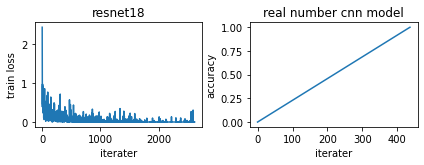

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Parameter, init
from torch.nn import Conv2d, Linear, BatchNorm2d
from torch.nn.functional import relu
from torchvision import datasets, transforms

import torch.optim as optim
if __name__ == '__main__':

    trans = transforms.Compose([
        transforms.Resize(56),
        transforms.CenterCrop(56),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (1.0,))
    ])
    #"C:\Users\86130\Downloads\COVID-CT-master (1)\COVID-CT-master\covid19-lung-ct-scans\COVID-19_Lung_CT_Scans\COVID-19"
    #"C:\Users\86130\Downloads\COVID-CT-master (1)\COVID-CT-master\covid19-lung-ct-scans\COVID-19_Lung_CT_Scans"

    #这里可以换数据集

    # trainset = CovidCTDataset(root_dir='COVID-19_Lung_CT_Scans',
    #                           txt_COVID='COVID-19_Lung_CT_Scans/COVID-19',
    #                           txt_NonCOVID='COVID-19_Lung_CT_Scans/Non-COVID-19',
    #                           transform=trans)

    trainset = CovidCTDataset(root_dir='Preprocessed CT scans',
                              txt_COVID='Preprocessed CT scans/pCT',
                              txt_NonCOVID='Preprocessed CT scans/nCT',
                              transform=trans)
    
    
    

    # valset = CovidCTDataset(root_dir='../../Images-processed',
    #                         txt_COVID='../../Data-split/COVID/valCT_COVID.txt',
    #                         txt_NonCOVID='../../Data-split/NonCOVID/valCT_NonCOVID.txt',
    #                         transform=trans)
    # testset = CovidCTDataset(root_dir='../../Images-processed',
    #                          txt_COVID='../../Data-split/COVID/testCT_COVID.txt',
    #                          txt_NonCOVID='../../Data-split/NonCOVID/testCT_NonCOVID.txt',
    #                          transform=trans)
    print(trainset.__len__())
    # print(valset.__len__())
    # print(testset.__len__())

    batchsize = 32
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    # train_set = datasets.MNIST('../data', train=True, transform=trans, download=True)
    # test_set = datasets.MNIST('../data', train=False, transform=trans, download=True)
    # train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=True)

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    # val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    # test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet18().to(device)

    criterion = nn.CrossEntropyLoss()  # cross entropy loss always use for classfication
    learn_rate=0.01
    momentum=0.9
    optimizer = optim.SGD(net.parameters(), learn_rate, momentum)

    # training real number model

    train_loss = []
    accuracy_list=[]
    
    for epoch in range(5):
        sum_loss = 0.0
        # read the data
        num_correct=0
        for i, (data,target) in enumerate(train_loader):
            data, target =  data.to(device), target.to(device)

            # zero the dradient
            optimizer.zero_grad()

            # forward + backward
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            

            pred=outputs.argmax(dim=1)
            num_correct+=torch.eq(pred,target).sum().float().item()

            train_loss.append(loss.item())

            if epoch==4:
              train_loss.append(loss.item())
              accuracy_list.append(num_correct/len(train_loader.dataset))

            # for every 100 batch training print mean loss once
            sum_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %d] loss: %.03f accuracy: %.03f'
                      % (epoch + 1, i + 1, sum_loss / 100,num_correct/len(train_loader.dataset)))
                sum_loss = 0.0
    


    plt.subplot(221)
    plt.title("resnet18")
    plt.xlabel("iterater")
    plt.ylabel("train loss")
    plt.plot(train_loss)

    plt.subplot(222)
    plt.title("real number cnn model")
    plt.xlabel("iterater")
    plt.ylabel("accuracy")
    plt.plot(accuracy_list)

    plt.tight_layout()

    plt.show()